In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

In [32]:
# define fully connected neuro network
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128,10)
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return F.softmax(x)

In [184]:
# Define model parameters and SGD
eta = 0.001
epochs = 5
log_interval = 10
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=eta, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [185]:
# load data

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,),(0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train = True, download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train = False, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size =32, shuffle = True)

In [186]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(epochs+1) ]
train_acc = []
test_acc = []

In [187]:
# train model

def train(epoch):
    net.train()
    correct = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.view(-1,28*28)
        optimizer.zero_grad()
        output = net(inputs)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1,keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        train_acc.append(100. * correct/len(trainloader.dataset))
        if batch_idx%log_interval == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(inputs), len(trainloader.dataset),100.*batch_idx/len(trainloader),
            loss.item()))
            
        train_losses.append(loss.item())
        train_counter.append((batch_idx*32)+((epoch-1)*len(trainloader.dataset)))
        # save the model
        torch.save(net.state_dict(), 'mnist-fc.pth')
        

In [188]:
# test 
def test():
    net = Net()
    #load model
    net.load_state_dict(torch.load("mnist-fc.pth"))
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data = data.view(-1,28*28)
            out = net(data)
            test_loss += F.cross_entropy(out,target,size_average=False).item()
            pred = out.data.max(1,keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
            test_loss /= len(testloader.dataset)
            test_losses.append(test_loss)
            test_acc.append(100. * correct/len(testloader.dataset))
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader.dataset), 100. * correct/len(testloader.dataset)))

In [ ]:
test()
for epoch in range(1,epochs+1):
    train(epoch)
    test()

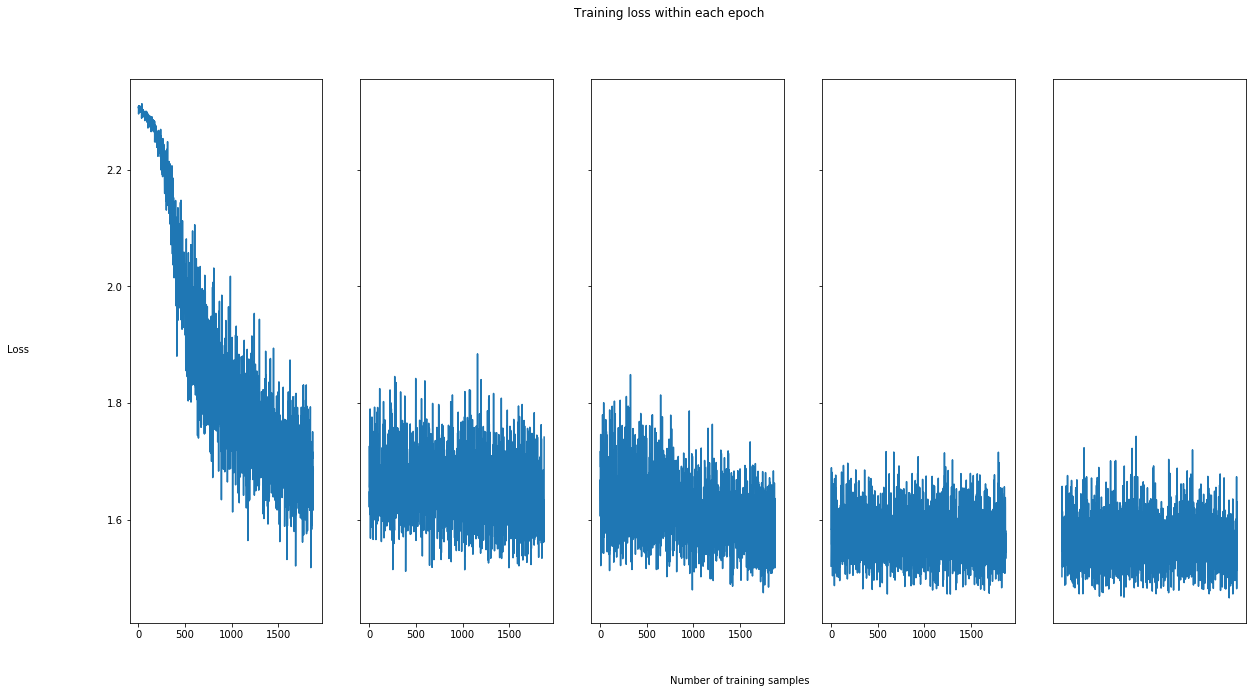

In [191]:
# plot train losses
fig, plots = plt.subplots(1,5,figsize = (20,10),sharex=True,sharey=True)
(p1,p2,p3,p4,p5) = plots

p1.plot(train_losses[0:1875])
p2.plot(train_losses[1875:3750])
p3.plot(train_losses[3750:5625])
p4.plot(train_losses[5625:7500])
p5.plot(train_losses[7500:9375])
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.suptitle('Training loss within each epoch')
fig.text(0.5,0.04,'Number of training samples')
fig.text(0.04,0.5,'Loss')
plt.savefig('train_loss.png')

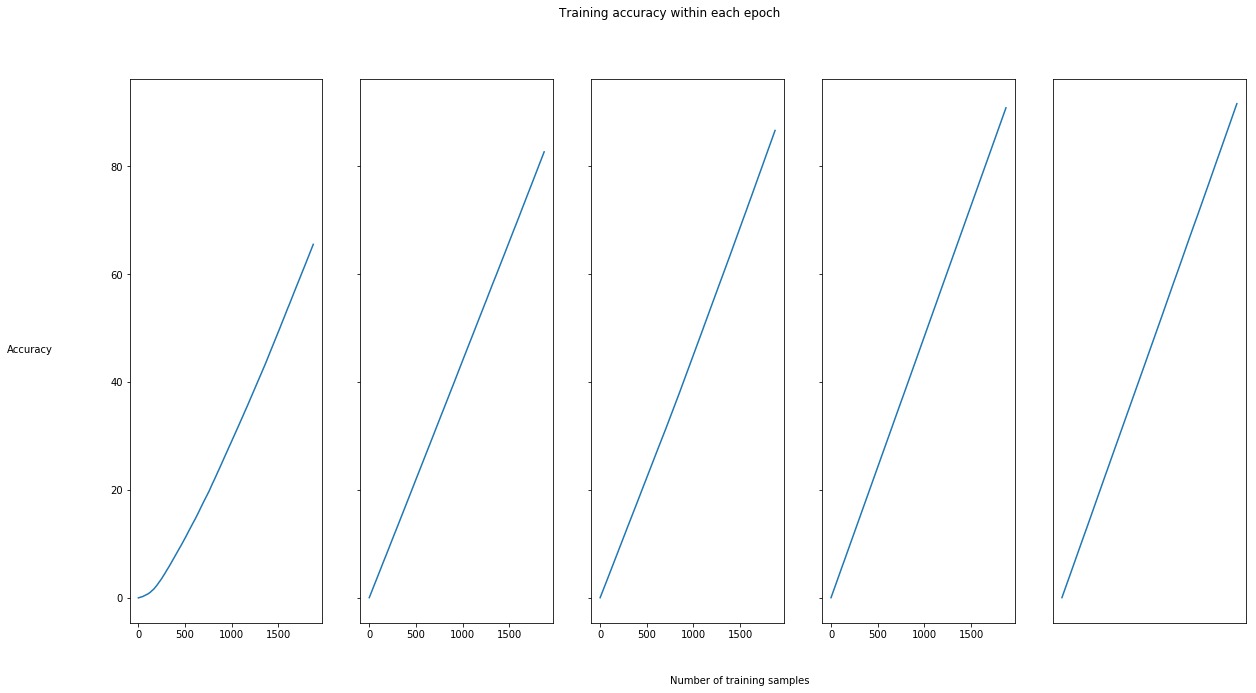

In [195]:
# plot train accuracy
fig, plots = plt.subplots(1,5,figsize = (20,10),sharex=True,sharey=True)
(p1,p2,p3,p4,p5) = plots

p1.plot(train_acc[0:1875])
p2.plot(train_acc[1875:3750])
p3.plot(train_acc[3750:5625])
p4.plot(train_acc[5625:7500])
p5.plot(train_acc[7500:9375])
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.suptitle('Training accuracy within each epoch')
fig.text(0.5,0.04,'Number of training samples')
fig.text(0.04,0.5,'Accuracy')
plt.savefig('train_acc.png')

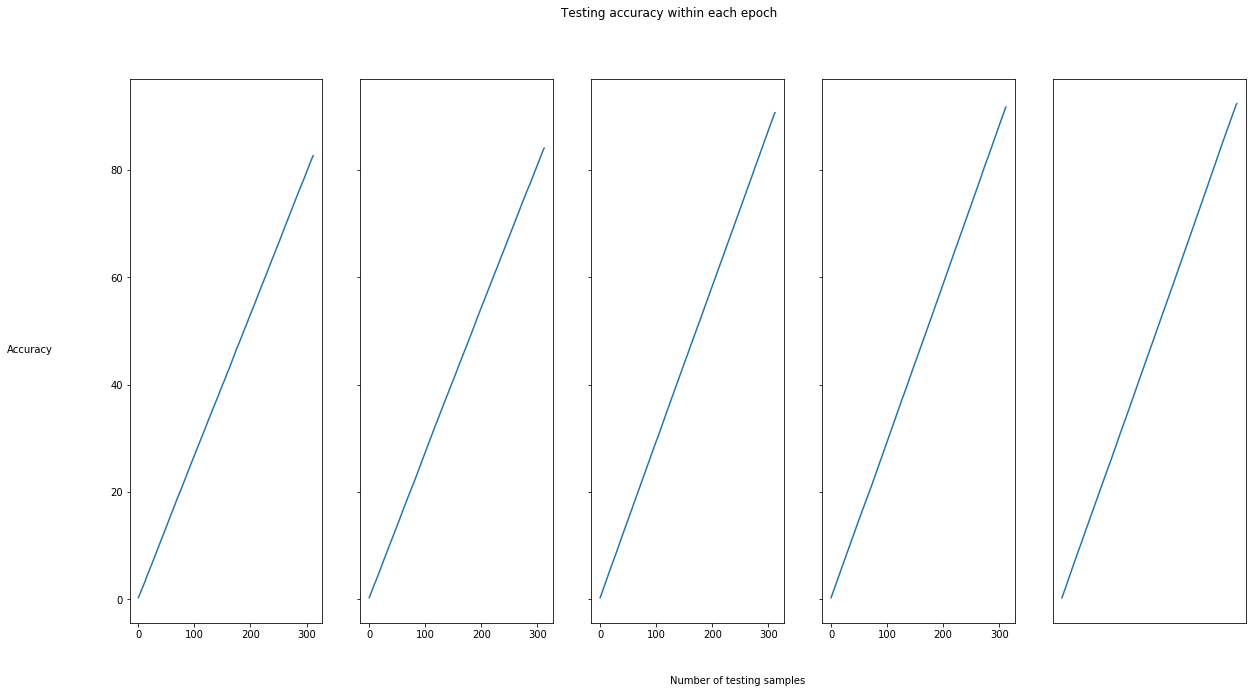

In [210]:
# plot testing accuracy
fig, plots = plt.subplots(1,5,figsize = (20,10),sharex=True,sharey=True)
(p1,p2,p3,p4,p5) = plots

p1.plot(test_acc[313:626])
p2.plot(test_acc[626:939])
p3.plot(test_acc[939:1252])
p4.plot(test_acc[1252:1565])
p5.plot(test_acc[1565:1878])
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.suptitle('Testing accuracy within each epoch')
fig.text(0.5,0.04,'Number of testing samples')
fig.text(0.04,0.5,'Accuracy')
plt.savefig('test_acc.png')